In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, \
                                    Flatten, Conv1D, MaxPooling1D, Dropout, \
                                    Concatenate, GlobalMaxPool1D, GlobalAvgPool1D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_cnn(conv_num=1):
    filter_size = 64

    input_layer = Input(shape=input_shape)
    x = input_layer

    layer_outputs = []
    for i in range(conv_num):
        x = Conv1D (kernel_size=5, filters=filter_size*(2**(i//4)), 
                          strides=1, padding='same')(x)
        x = Activation('relu')(x)
        x = MaxPooling1D(pool_size=3, strides=3)(x)
        layer_outputs.append(x)    
    
    x = Concatenate()([GlobalMaxPool1D()(output) for output in layer_outputs[-3:]])
    x = Dropout(0.5)(x)
    x = Dense(output_size, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=x)
    return model

In [9]:
for i in range(3, 9):
    model = build_cnn(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 16000, 64)    384         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 16000, 64)    0           conv1d[0][0]                     
__________________________________________________________________________________________________
max_pooling1d (MaxPoo

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 16000, 64)    384         input_3[0][0]                    
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 16000, 64)    0           conv1d_7[0][0]                   
__________________________________________________________________________________________________
max_pooling1d_7 (MaxPooling1D)  (None, 5333, 64)     0           activation_7[0][0]               
__________________________________________________________________________________________________
conv1d_8 (

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 16000, 64)    384         input_5[0][0]                    
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 16000, 64)    0           conv1d_18[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_18 (MaxPooling1D) (None, 5333, 64)     0           activation_18[0][0]              
__________________________________________________________________________________________________
conv1d_19 

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.6390 - acc: 0.1370
Epoch 00001: val_loss improved from inf to 2.41191, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_DO_3_conv_checkpoint/001-2.4119.hdf5
36805/36805 [==============================] - 34s 913us/sample - loss: 2.6390 - acc: 0.1370 - val_loss: 2.4119 - val_acc: 0.2383
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3405 - acc: 0.2207
Epoch 00002: val_loss improved from 2.41191 to 2.10952, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_DO_3_conv_checkpoint/002-2.1095.hdf5
36805/36805 [==============================] - 31s 855us/sample - loss: 2.3404 - acc: 0.2207 - val_loss: 2.1095 - val_acc: 0.3371
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss

36800/36805 [============================>.] - ETA: 0s - loss: 1.3171 - acc: 0.5669
Epoch 00021: val_loss improved from 1.05441 to 1.03375, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_DO_3_conv_checkpoint/021-1.0338.hdf5
36805/36805 [==============================] - 31s 849us/sample - loss: 1.3172 - acc: 0.5669 - val_loss: 1.0338 - val_acc: 0.6797
Epoch 22/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3062 - acc: 0.5743
Epoch 00022: val_loss improved from 1.03375 to 1.01566, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_DO_3_conv_checkpoint/022-1.0157.hdf5
36805/36805 [==============================] - 31s 843us/sample - loss: 1.3062 - acc: 0.5744 - val_loss: 1.0157 - val_acc: 0.6816
Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2806 - acc: 0.5820
Epoch 00023: val_loss improved from 1.01566 to 1.00633, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_DO_3_conv_checkpoint/023-1.0063.hdf5
36805/

36800/36805 [============================>.] - ETA: 0s - loss: 1.1058 - acc: 0.6455
Epoch 00043: val_loss improved from 0.82622 to 0.82346, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_DO_3_conv_checkpoint/043-0.8235.hdf5
36805/36805 [==============================] - 31s 844us/sample - loss: 1.1058 - acc: 0.6455 - val_loss: 0.8235 - val_acc: 0.7438
Epoch 44/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0956 - acc: 0.6477
Epoch 00044: val_loss did not improve from 0.82346
36805/36805 [==============================] - 31s 844us/sample - loss: 1.0956 - acc: 0.6477 - val_loss: 0.8263 - val_acc: 0.7452
Epoch 45/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0905 - acc: 0.6492
Epoch 00045: val_loss improved from 0.82346 to 0.82181, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_DO_3_conv_checkpoint/045-0.8218.hdf5
36805/36805 [==============================] - 31s 846us/sample - loss: 1.0906 - acc: 0.6492 - val_loss: 0.

36800/36805 [============================>.] - ETA: 0s - loss: 1.0143 - acc: 0.6774
Epoch 00067: val_loss did not improve from 0.74141
36805/36805 [==============================] - 31s 856us/sample - loss: 1.0142 - acc: 0.6774 - val_loss: 0.7452 - val_acc: 0.7731
Epoch 68/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0137 - acc: 0.6745
Epoch 00068: val_loss did not improve from 0.74141
36805/36805 [==============================] - 31s 836us/sample - loss: 1.0136 - acc: 0.6745 - val_loss: 0.7520 - val_acc: 0.7657
Epoch 69/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0171 - acc: 0.6767
Epoch 00069: val_loss improved from 0.74141 to 0.73579, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_DO_3_conv_checkpoint/069-0.7358.hdf5
36805/36805 [==============================] - 31s 839us/sample - loss: 1.0171 - acc: 0.6768 - val_loss: 0.7358 - val_acc: 0.7792
Epoch 70/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.

Epoch 93/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9668 - acc: 0.6917
Epoch 00093: val_loss did not improve from 0.69497
36805/36805 [==============================] - 31s 839us/sample - loss: 0.9669 - acc: 0.6917 - val_loss: 0.6953 - val_acc: 0.7878
Epoch 94/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9677 - acc: 0.6922
Epoch 00094: val_loss did not improve from 0.69497
36805/36805 [==============================] - 31s 835us/sample - loss: 0.9680 - acc: 0.6921 - val_loss: 0.6963 - val_acc: 0.7920
Epoch 95/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9631 - acc: 0.6932
Epoch 00095: val_loss improved from 0.69497 to 0.68498, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_DO_3_conv_checkpoint/095-0.6850.hdf5
36805/36805 [==============================] - 31s 835us/sample - loss: 0.9631 - acc: 0.6932 - val_loss: 0.6850 - val_acc: 0.7950
Epoch 96/500
36800/36805 [============================>.] - ETA: 

Epoch 119/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9220 - acc: 0.7074
Epoch 00119: val_loss did not improve from 0.64452
36805/36805 [==============================] - 31s 838us/sample - loss: 0.9221 - acc: 0.7074 - val_loss: 0.6452 - val_acc: 0.8130
Epoch 120/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9198 - acc: 0.7084
Epoch 00120: val_loss improved from 0.64452 to 0.64186, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_DO_3_conv_checkpoint/120-0.6419.hdf5
36805/36805 [==============================] - 31s 837us/sample - loss: 0.9197 - acc: 0.7085 - val_loss: 0.6419 - val_acc: 0.8125
Epoch 121/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9182 - acc: 0.7083
Epoch 00121: val_loss improved from 0.64186 to 0.63909, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_DO_3_conv_checkpoint/121-0.6391.hdf5
36805/36805 [==============================] - 31s 839us/sample - loss: 0.9182 - acc: 0.708

36800/36805 [============================>.] - ETA: 0s - loss: 0.8931 - acc: 0.7179
Epoch 00144: val_loss did not improve from 0.61497
36805/36805 [==============================] - 31s 841us/sample - loss: 0.8931 - acc: 0.7178 - val_loss: 0.6227 - val_acc: 0.8157
Epoch 145/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8844 - acc: 0.7173
Epoch 00145: val_loss improved from 0.61497 to 0.61195, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_DO_3_conv_checkpoint/145-0.6119.hdf5
36805/36805 [==============================] - 31s 845us/sample - loss: 0.8844 - acc: 0.7173 - val_loss: 0.6119 - val_acc: 0.8199
Epoch 146/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8863 - acc: 0.7172
Epoch 00146: val_loss did not improve from 0.61195
36805/36805 [==============================] - 31s 840us/sample - loss: 0.8863 - acc: 0.7172 - val_loss: 0.6183 - val_acc: 0.8220
Epoch 147/500
36800/36805 [============================>.] - ETA: 0s - loss:

Epoch 172/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8613 - acc: 0.7267
Epoch 00172: val_loss did not improve from 0.58763
36805/36805 [==============================] - 31s 840us/sample - loss: 0.8613 - acc: 0.7267 - val_loss: 0.5909 - val_acc: 0.8304
Epoch 173/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8604 - acc: 0.7255
Epoch 00173: val_loss did not improve from 0.58763
36805/36805 [==============================] - 31s 842us/sample - loss: 0.8604 - acc: 0.7255 - val_loss: 0.5907 - val_acc: 0.8344
Epoch 174/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8581 - acc: 0.7274
Epoch 00174: val_loss did not improve from 0.58763
36805/36805 [==============================] - 31s 837us/sample - loss: 0.8581 - acc: 0.7274 - val_loss: 0.5882 - val_acc: 0.8314
Epoch 175/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8671 - acc: 0.7252
Epoch 00175: val_loss improved from 0.58763 to 0.58187, saving mo

Epoch 200/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8453 - acc: 0.7316
Epoch 00200: val_loss did not improve from 0.57119
36805/36805 [==============================] - 31s 839us/sample - loss: 0.8453 - acc: 0.7316 - val_loss: 0.5730 - val_acc: 0.8376
Epoch 201/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8419 - acc: 0.7324
Epoch 00201: val_loss did not improve from 0.57119
36805/36805 [==============================] - 31s 841us/sample - loss: 0.8419 - acc: 0.7323 - val_loss: 0.5746 - val_acc: 0.8353
Epoch 202/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8355 - acc: 0.7338
Epoch 00202: val_loss improved from 0.57119 to 0.56709, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_DO_3_conv_checkpoint/202-0.5671.hdf5
36805/36805 [==============================] - 31s 840us/sample - loss: 0.8355 - acc: 0.7338 - val_loss: 0.5671 - val_acc: 0.8402
Epoch 203/500
36800/36805 [============================>.] - E

Epoch 229/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8218 - acc: 0.7383
Epoch 00229: val_loss did not improve from 0.56562
36805/36805 [==============================] - 31s 837us/sample - loss: 0.8219 - acc: 0.7383 - val_loss: 0.5681 - val_acc: 0.8379
Epoch 230/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8200 - acc: 0.7405
Epoch 00230: val_loss improved from 0.56562 to 0.56527, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_DO_3_conv_checkpoint/230-0.5653.hdf5
36805/36805 [==============================] - 31s 841us/sample - loss: 0.8199 - acc: 0.7406 - val_loss: 0.5653 - val_acc: 0.8402
Epoch 231/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8206 - acc: 0.7377
Epoch 00231: val_loss did not improve from 0.56527
36805/36805 [==============================] - 31s 838us/sample - loss: 0.8206 - acc: 0.7378 - val_loss: 0.5713 - val_acc: 0.8388
Epoch 232/500
36800/36805 [============================>.] - E

Epoch 257/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8004 - acc: 0.7463
Epoch 00257: val_loss improved from 0.55251 to 0.54701, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_DO_3_conv_checkpoint/257-0.5470.hdf5
36805/36805 [==============================] - 31s 840us/sample - loss: 0.8004 - acc: 0.7463 - val_loss: 0.5470 - val_acc: 0.8463
Epoch 258/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8031 - acc: 0.7445
Epoch 00258: val_loss did not improve from 0.54701
36805/36805 [==============================] - 31s 840us/sample - loss: 0.8031 - acc: 0.7445 - val_loss: 0.5521 - val_acc: 0.8446
Epoch 259/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8072 - acc: 0.7447
Epoch 00259: val_loss did not improve from 0.54701
36805/36805 [==============================] - 31s 842us/sample - loss: 0.8072 - acc: 0.7447 - val_loss: 0.5574 - val_acc: 0.8444
Epoch 260/500
36800/36805 [============================>.] - E

Epoch 286/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7922 - acc: 0.7467
Epoch 00286: val_loss did not improve from 0.54451
36805/36805 [==============================] - 31s 837us/sample - loss: 0.7922 - acc: 0.7467 - val_loss: 0.5647 - val_acc: 0.8407
Epoch 287/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7969 - acc: 0.7468
Epoch 00287: val_loss did not improve from 0.54451
36805/36805 [==============================] - 31s 837us/sample - loss: 0.7969 - acc: 0.7468 - val_loss: 0.5535 - val_acc: 0.8439
Epoch 288/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7924 - acc: 0.7489
Epoch 00288: val_loss did not improve from 0.54451
36805/36805 [==============================] - 31s 839us/sample - loss: 0.7924 - acc: 0.7489 - val_loss: 0.5517 - val_acc: 0.8423
Epoch 289/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7932 - acc: 0.7466
Epoch 00289: val_loss did not improve from 0.54451
36805/36805 [=

Epoch 315/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7828 - acc: 0.7503
Epoch 00315: val_loss did not improve from 0.53796
36805/36805 [==============================] - 31s 841us/sample - loss: 0.7830 - acc: 0.7503 - val_loss: 0.5462 - val_acc: 0.8416
Epoch 316/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7806 - acc: 0.7533
Epoch 00316: val_loss did not improve from 0.53796
36805/36805 [==============================] - 31s 838us/sample - loss: 0.7806 - acc: 0.7533 - val_loss: 0.5545 - val_acc: 0.8442
Epoch 317/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7863 - acc: 0.7493
Epoch 00317: val_loss did not improve from 0.53796
36805/36805 [==============================] - 31s 835us/sample - loss: 0.7863 - acc: 0.7493 - val_loss: 0.5460 - val_acc: 0.8467
Epoch 318/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7814 - acc: 0.7516
Epoch 00318: val_loss did not improve from 0.53796
36805/36805 [=

36800/36805 [============================>.] - ETA: 0s - loss: 0.7684 - acc: 0.7530
Epoch 00344: val_loss did not improve from 0.53477
36805/36805 [==============================] - 31s 843us/sample - loss: 0.7683 - acc: 0.7530 - val_loss: 0.5411 - val_acc: 0.8472
Epoch 345/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7623 - acc: 0.7569
Epoch 00345: val_loss did not improve from 0.53477
36805/36805 [==============================] - 31s 837us/sample - loss: 0.7622 - acc: 0.7570 - val_loss: 0.5418 - val_acc: 0.8458
Epoch 346/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7718 - acc: 0.7537
Epoch 00346: val_loss did not improve from 0.53477
36805/36805 [==============================] - 31s 841us/sample - loss: 0.7718 - acc: 0.7537 - val_loss: 0.5379 - val_acc: 0.8474
Epoch 347/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7657 - acc: 0.7548
Epoch 00347: val_loss did not improve from 0.53477
36805/36805 [===============

Epoch 373/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7619 - acc: 0.7584
Epoch 00373: val_loss did not improve from 0.53259
36805/36805 [==============================] - 31s 836us/sample - loss: 0.7620 - acc: 0.7584 - val_loss: 0.5353 - val_acc: 0.8472
Epoch 374/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7615 - acc: 0.7560
Epoch 00374: val_loss improved from 0.53259 to 0.52718, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_DO_3_conv_checkpoint/374-0.5272.hdf5
36805/36805 [==============================] - 31s 839us/sample - loss: 0.7614 - acc: 0.7560 - val_loss: 0.5272 - val_acc: 0.8460
Epoch 375/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7573 - acc: 0.7575
Epoch 00375: val_loss did not improve from 0.52718
36805/36805 [==============================] - 31s 841us/sample - loss: 0.7572 - acc: 0.7576 - val_loss: 0.5385 - val_acc: 0.8456
Epoch 376/500
36800/36805 [============================>.] - E

Epoch 402/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7537 - acc: 0.7610
Epoch 00402: val_loss did not improve from 0.52464
36805/36805 [==============================] - 31s 839us/sample - loss: 0.7537 - acc: 0.7610 - val_loss: 0.5344 - val_acc: 0.8428
Epoch 403/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7487 - acc: 0.7613
Epoch 00403: val_loss did not improve from 0.52464
36805/36805 [==============================] - 31s 835us/sample - loss: 0.7487 - acc: 0.7613 - val_loss: 0.5331 - val_acc: 0.8446
Epoch 404/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7528 - acc: 0.7599
Epoch 00404: val_loss did not improve from 0.52464
36805/36805 [==============================] - 31s 836us/sample - loss: 0.7529 - acc: 0.7599 - val_loss: 0.5341 - val_acc: 0.8463
Epoch 405/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7469 - acc: 0.7609
Epoch 00405: val_loss did not improve from 0.52464
36805/36805 [=

Epoch 431/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7426 - acc: 0.7626
Epoch 00431: val_loss did not improve from 0.52288
36805/36805 [==============================] - 31s 836us/sample - loss: 0.7425 - acc: 0.7626 - val_loss: 0.5278 - val_acc: 0.8500
Epoch 432/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7486 - acc: 0.7608
Epoch 00432: val_loss did not improve from 0.52288
36805/36805 [==============================] - 31s 838us/sample - loss: 0.7486 - acc: 0.7608 - val_loss: 0.5369 - val_acc: 0.8458
Epoch 433/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7417 - acc: 0.7646
Epoch 00433: val_loss did not improve from 0.52288
36805/36805 [==============================] - 31s 839us/sample - loss: 0.7417 - acc: 0.7646 - val_loss: 0.5306 - val_acc: 0.8437
Epoch 434/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7356 - acc: 0.7660
Epoch 00434: val_loss did not improve from 0.52288
36805/36805 [=

Epoch 460/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7381 - acc: 0.7648
Epoch 00460: val_loss did not improve from 0.51789
36805/36805 [==============================] - 31s 840us/sample - loss: 0.7381 - acc: 0.7648 - val_loss: 0.5339 - val_acc: 0.8453
Epoch 461/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7265 - acc: 0.7701
Epoch 00461: val_loss did not improve from 0.51789
36805/36805 [==============================] - 31s 837us/sample - loss: 0.7265 - acc: 0.7701 - val_loss: 0.5240 - val_acc: 0.8481
Epoch 462/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7295 - acc: 0.7647
Epoch 00462: val_loss did not improve from 0.51789
36805/36805 [==============================] - 31s 837us/sample - loss: 0.7295 - acc: 0.7647 - val_loss: 0.5340 - val_acc: 0.8477
Epoch 463/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7265 - acc: 0.7691
Epoch 00463: val_loss did not improve from 0.51789
36805/36805 [=

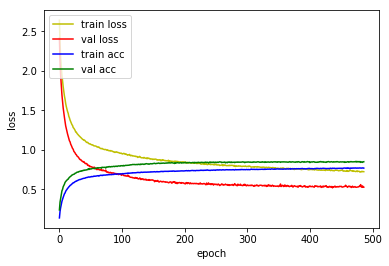

4815/4815 [==============================] - 2s 394us/sample - loss: 0.6007 - acc: 0.8214
Loss: 0.6007182153462126 Accuracy: 0.82139146

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5566 - acc: 0.1607
Epoch 00001: val_loss improved from inf to 2.20721, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_DO_4_conv_checkpoint/001-2.2072.hdf5
36805/36805 [==============================] - 31s 856us/sample - loss: 2.5565 - acc: 0.1607 - val_loss: 2.2072 - val_acc: 0.3058
Epoch 2/500
36736/36805 [============================>.] - ETA: 0s - loss: 2.1920 - acc: 0.2630
Epoch 00002: val_loss improved from 2.20721 to 1.93123, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_DO_4_conv_checkpoint/002-1.9312.hdf5
36805/36805 [==============================] - 30s 814us/sample - loss: 2.1916 - acc: 0.2631 - val_loss: 1.9312 - val_acc: 0.4067
Epoch 3/500
36736/36805 [============================>.] - ETA

36736/36805 [============================>.] - ETA: 0s - loss: 1.0513 - acc: 0.6600
Epoch 00022: val_loss improved from 0.79952 to 0.76679, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_DO_4_conv_checkpoint/022-0.7668.hdf5
36805/36805 [==============================] - 30s 815us/sample - loss: 1.0509 - acc: 0.6600 - val_loss: 0.7668 - val_acc: 0.7699
Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0286 - acc: 0.6701
Epoch 00023: val_loss improved from 0.76679 to 0.76299, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_DO_4_conv_checkpoint/023-0.7630.hdf5
36805/36805 [==============================] - 30s 815us/sample - loss: 1.0284 - acc: 0.6701 - val_loss: 0.7630 - val_acc: 0.7715
Epoch 24/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.0159 - acc: 0.6755
Epoch 00024: val_loss improved from 0.76299 to 0.75382, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_DO_4_conv_checkpoint/024-0.7538.hdf5
36805/

Epoch 45/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.8174 - acc: 0.7438
Epoch 00045: val_loss did not improve from 0.56717
36805/36805 [==============================] - 30s 811us/sample - loss: 0.8174 - acc: 0.7438 - val_loss: 0.5780 - val_acc: 0.8283
Epoch 46/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8148 - acc: 0.7427
Epoch 00046: val_loss improved from 0.56717 to 0.56514, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_DO_4_conv_checkpoint/046-0.5651.hdf5
36805/36805 [==============================] - 30s 813us/sample - loss: 0.8148 - acc: 0.7428 - val_loss: 0.5651 - val_acc: 0.8360
Epoch 47/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8109 - acc: 0.7445
Epoch 00047: val_loss did not improve from 0.56514
36805/36805 [==============================] - 30s 812us/sample - loss: 0.8108 - acc: 0.7445 - val_loss: 0.5663 - val_acc: 0.8316
Epoch 48/500
36800/36805 [============================>.] - ETA: 

36736/36805 [============================>.] - ETA: 0s - loss: 0.7042 - acc: 0.7826
Epoch 00070: val_loss did not improve from 0.47040
36805/36805 [==============================] - 30s 815us/sample - loss: 0.7041 - acc: 0.7826 - val_loss: 0.4730 - val_acc: 0.8612
Epoch 71/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6963 - acc: 0.7842
Epoch 00071: val_loss improved from 0.47040 to 0.46139, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_DO_4_conv_checkpoint/071-0.4614.hdf5
36805/36805 [==============================] - 30s 813us/sample - loss: 0.6962 - acc: 0.7842 - val_loss: 0.4614 - val_acc: 0.8616
Epoch 72/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.7044 - acc: 0.7782
Epoch 00072: val_loss did not improve from 0.46139
36805/36805 [==============================] - 30s 813us/sample - loss: 0.7047 - acc: 0.7781 - val_loss: 0.4712 - val_acc: 0.8616
Epoch 73/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.

Epoch 95/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6402 - acc: 0.7985
Epoch 00095: val_loss did not improve from 0.42763
36805/36805 [==============================] - 30s 812us/sample - loss: 0.6403 - acc: 0.7985 - val_loss: 0.4444 - val_acc: 0.8663
Epoch 96/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.6388 - acc: 0.8005
Epoch 00096: val_loss improved from 0.42763 to 0.42582, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_DO_4_conv_checkpoint/096-0.4258.hdf5
36805/36805 [==============================] - 30s 818us/sample - loss: 0.6391 - acc: 0.8004 - val_loss: 0.4258 - val_acc: 0.8719
Epoch 97/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6382 - acc: 0.7990
Epoch 00097: val_loss improved from 0.42582 to 0.42040, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_DO_4_conv_checkpoint/097-0.4204.hdf5
36805/36805 [==============================] - 30s 815us/sample - loss: 0.6382 - acc: 0.7990 -

36800/36805 [============================>.] - ETA: 0s - loss: 0.5873 - acc: 0.8146
Epoch 00120: val_loss improved from 0.39961 to 0.39822, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_DO_4_conv_checkpoint/120-0.3982.hdf5
36805/36805 [==============================] - 30s 821us/sample - loss: 0.5874 - acc: 0.8145 - val_loss: 0.3982 - val_acc: 0.8817
Epoch 121/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.5898 - acc: 0.8143
Epoch 00121: val_loss improved from 0.39822 to 0.39557, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_DO_4_conv_checkpoint/121-0.3956.hdf5
36805/36805 [==============================] - 30s 817us/sample - loss: 0.5894 - acc: 0.8143 - val_loss: 0.3956 - val_acc: 0.8805
Epoch 122/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.5869 - acc: 0.8153
Epoch 00122: val_loss did not improve from 0.39557
36805/36805 [==============================] - 30s 815us/sample - loss: 0.5869 - acc: 0.8152 - val_loss: 

Epoch 147/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5547 - acc: 0.8254
Epoch 00147: val_loss did not improve from 0.37897
36805/36805 [==============================] - 30s 813us/sample - loss: 0.5547 - acc: 0.8254 - val_loss: 0.3833 - val_acc: 0.8838
Epoch 148/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.5559 - acc: 0.8229
Epoch 00148: val_loss did not improve from 0.37897
36805/36805 [==============================] - 30s 817us/sample - loss: 0.5559 - acc: 0.8229 - val_loss: 0.3833 - val_acc: 0.8840
Epoch 149/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.5478 - acc: 0.8268
Epoch 00149: val_loss did not improve from 0.37897
36805/36805 [==============================] - 30s 811us/sample - loss: 0.5480 - acc: 0.8267 - val_loss: 0.3948 - val_acc: 0.8782
Epoch 150/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5464 - acc: 0.8254
Epoch 00150: val_loss did not improve from 0.37897
36805/36805 [=

Epoch 174/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5189 - acc: 0.8374
Epoch 00174: val_loss did not improve from 0.36652
36805/36805 [==============================] - 30s 817us/sample - loss: 0.5191 - acc: 0.8373 - val_loss: 0.3756 - val_acc: 0.8868
Epoch 175/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5124 - acc: 0.8385
Epoch 00175: val_loss did not improve from 0.36652
36805/36805 [==============================] - 30s 815us/sample - loss: 0.5124 - acc: 0.8385 - val_loss: 0.3685 - val_acc: 0.8905
Epoch 176/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5242 - acc: 0.8358
Epoch 00176: val_loss improved from 0.36652 to 0.36268, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_DO_4_conv_checkpoint/176-0.3627.hdf5
36805/36805 [==============================] - 30s 816us/sample - loss: 0.5242 - acc: 0.8358 - val_loss: 0.3627 - val_acc: 0.8915
Epoch 177/500
36800/36805 [============================>.] - E

Epoch 202/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4934 - acc: 0.8418
Epoch 00202: val_loss did not improve from 0.35382
36805/36805 [==============================] - 30s 817us/sample - loss: 0.4934 - acc: 0.8418 - val_loss: 0.3630 - val_acc: 0.8924
Epoch 203/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4993 - acc: 0.8402
Epoch 00203: val_loss did not improve from 0.35382
36805/36805 [==============================] - 30s 813us/sample - loss: 0.4992 - acc: 0.8403 - val_loss: 0.3637 - val_acc: 0.8877
Epoch 204/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4931 - acc: 0.8440
Epoch 00204: val_loss did not improve from 0.35382
36805/36805 [==============================] - 30s 815us/sample - loss: 0.4933 - acc: 0.8440 - val_loss: 0.3592 - val_acc: 0.8908
Epoch 205/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4856 - acc: 0.8463
Epoch 00205: val_loss did not improve from 0.35382
36805/36805 [=

36736/36805 [============================>.] - ETA: 0s - loss: 0.4683 - acc: 0.8497
Epoch 00230: val_loss did not improve from 0.35024
36805/36805 [==============================] - 30s 818us/sample - loss: 0.4682 - acc: 0.8498 - val_loss: 0.3562 - val_acc: 0.8959
Epoch 231/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4661 - acc: 0.8512
Epoch 00231: val_loss did not improve from 0.35024
36805/36805 [==============================] - 30s 816us/sample - loss: 0.4661 - acc: 0.8512 - val_loss: 0.3506 - val_acc: 0.8947
Epoch 232/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.4668 - acc: 0.8504
Epoch 00232: val_loss did not improve from 0.35024
36805/36805 [==============================] - 30s 816us/sample - loss: 0.4670 - acc: 0.8502 - val_loss: 0.3567 - val_acc: 0.8940
Epoch 233/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.4685 - acc: 0.8507
Epoch 00233: val_loss did not improve from 0.35024
36805/36805 [===============

Epoch 258/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4526 - acc: 0.8557
Epoch 00258: val_loss did not improve from 0.34468
36805/36805 [==============================] - 30s 819us/sample - loss: 0.4525 - acc: 0.8556 - val_loss: 0.3622 - val_acc: 0.8887
Epoch 259/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.4457 - acc: 0.8556
Epoch 00259: val_loss did not improve from 0.34468
36805/36805 [==============================] - 30s 822us/sample - loss: 0.4457 - acc: 0.8556 - val_loss: 0.3522 - val_acc: 0.8956
Epoch 260/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4494 - acc: 0.8567
Epoch 00260: val_loss did not improve from 0.34468
36805/36805 [==============================] - 30s 821us/sample - loss: 0.4494 - acc: 0.8568 - val_loss: 0.3492 - val_acc: 0.8915
Epoch 261/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4507 - acc: 0.8533
Epoch 00261: val_loss did not improve from 0.34468
36805/36805 [=

36800/36805 [============================>.] - ETA: 0s - loss: 0.4348 - acc: 0.8618
Epoch 00287: val_loss did not improve from 0.34468
36805/36805 [==============================] - 31s 829us/sample - loss: 0.4348 - acc: 0.8618 - val_loss: 0.3600 - val_acc: 0.8924
Epoch 288/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4288 - acc: 0.8614
Epoch 00288: val_loss did not improve from 0.34468
36805/36805 [==============================] - 31s 830us/sample - loss: 0.4289 - acc: 0.8614 - val_loss: 0.3530 - val_acc: 0.8945
Epoch 289/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.4341 - acc: 0.8583
Epoch 00289: val_loss did not improve from 0.34468
36805/36805 [==============================] - 30s 815us/sample - loss: 0.4340 - acc: 0.8584 - val_loss: 0.3485 - val_acc: 0.8959
Epoch 290/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4314 - acc: 0.8605
Epoch 00290: val_loss did not improve from 0.34468
36805/36805 [===============

36736/36805 [============================>.] - ETA: 0s - loss: 0.4148 - acc: 0.8654
Epoch 00316: val_loss did not improve from 0.33961
36805/36805 [==============================] - 30s 819us/sample - loss: 0.4147 - acc: 0.8654 - val_loss: 0.3450 - val_acc: 0.8945
Epoch 317/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.4157 - acc: 0.8646
Epoch 00317: val_loss did not improve from 0.33961
36805/36805 [==============================] - 30s 822us/sample - loss: 0.4155 - acc: 0.8646 - val_loss: 0.3556 - val_acc: 0.8954
Epoch 318/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4134 - acc: 0.8662- ETA: 1s
Epoch 00318: val_loss did not improve from 0.33961
36805/36805 [==============================] - 30s 821us/sample - loss: 0.4134 - acc: 0.8662 - val_loss: 0.3489 - val_acc: 0.8924
Epoch 319/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4180 - acc: 0.8656
Epoch 00319: val_loss did not improve from 0.33961
36805/36805 [======

Epoch 346/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4056 - acc: 0.8693
Epoch 00346: val_loss did not improve from 0.33961
36805/36805 [==============================] - 30s 824us/sample - loss: 0.4056 - acc: 0.8693 - val_loss: 0.3544 - val_acc: 0.8940
Epoch 347/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3994 - acc: 0.8698
Epoch 00347: val_loss did not improve from 0.33961
36805/36805 [==============================] - 30s 818us/sample - loss: 0.3994 - acc: 0.8698 - val_loss: 0.3563 - val_acc: 0.8917
Epoch 348/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.4054 - acc: 0.8704
Epoch 00348: val_loss did not improve from 0.33961
36805/36805 [==============================] - 30s 822us/sample - loss: 0.4052 - acc: 0.8704 - val_loss: 0.3518 - val_acc: 0.8938
Epoch 349/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.4011 - acc: 0.8690
Epoch 00349: val_loss did not improve from 0.33961
36805/36805 [=

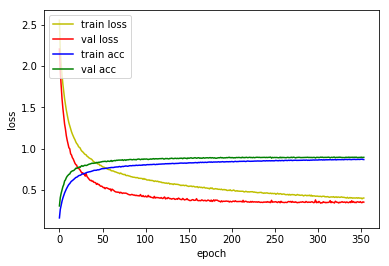

4815/4815 [==============================] - 2s 404us/sample - loss: 0.4084 - acc: 0.8768
Loss: 0.40840566355119984 Accuracy: 0.8768432

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4743 - acc: 0.1772
Epoch 00001: val_loss improved from inf to 1.99777, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_DO_5_conv_checkpoint/001-1.9978.hdf5
36805/36805 [==============================] - 33s 899us/sample - loss: 2.4743 - acc: 0.1773 - val_loss: 1.9978 - val_acc: 0.3720
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9557 - acc: 0.3457
Epoch 00002: val_loss improved from 1.99777 to 1.53245, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_DO_5_conv_checkpoint/002-1.5324.hdf5
36805/36805 [==============================] - 31s 833us/sample - loss: 1.9557 - acc: 0.3457 - val_loss: 1.5324 - val_acc: 0.5330
Epoch 3/500
36800/36805 [============================>.] - ETA

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5096 - acc: 0.8432
Epoch 00024: val_loss improved from 0.33795 to 0.33331, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_DO_5_conv_checkpoint/024-0.3333.hdf5
36805/36805 [==============================] - 31s 833us/sample - loss: 0.5097 - acc: 0.8431 - val_loss: 0.3333 - val_acc: 0.9019
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5000 - acc: 0.8468
Epoch 00025: val_loss improved from 0.33331 to 0.31245, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_DO_5_conv_checkpoint/025-0.3125.hdf5
36805/36805 [==============================] - 31s 835us/sample - loss: 0.5001 - acc: 0.8468 - val_loss: 0.3125 - val_acc: 0.9080
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4899 - acc: 0.8493
Epoch 00026: val_loss improved from 0.31245 to 0.30513, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_DO_5_conv_checkpoint/026-0.305

36800/36805 [============================>.] - ETA: 0s - loss: 0.3619 - acc: 0.8882- ETA: 0s - loss: 0.3619 - acc: 0.888
Epoch 00048: val_loss did not improve from 0.23895
36805/36805 [==============================] - 31s 834us/sample - loss: 0.3619 - acc: 0.8882 - val_loss: 0.2407 - val_acc: 0.9294
Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3612 - acc: 0.8885
Epoch 00049: val_loss did not improve from 0.23895
36805/36805 [==============================] - 31s 834us/sample - loss: 0.3611 - acc: 0.8885 - val_loss: 0.2407 - val_acc: 0.9320
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3598 - acc: 0.8899
Epoch 00050: val_loss improved from 0.23895 to 0.23300, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_DO_5_conv_checkpoint/050-0.2330.hdf5
36805/36805 [==============================] - 31s 833us/sample - loss: 0.3598 - acc: 0.8899 - val_loss: 0.2330 - val_acc: 0.9334
Epoch 51/500
36800/36805 [===============

Epoch 74/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2940 - acc: 0.9086
Epoch 00074: val_loss did not improve from 0.20783
36805/36805 [==============================] - 31s 836us/sample - loss: 0.2940 - acc: 0.9086 - val_loss: 0.2096 - val_acc: 0.9378
Epoch 75/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2917 - acc: 0.9091
Epoch 00075: val_loss did not improve from 0.20783
36805/36805 [==============================] - 31s 832us/sample - loss: 0.2916 - acc: 0.9091 - val_loss: 0.2092 - val_acc: 0.9401
Epoch 76/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2942 - acc: 0.9087
Epoch 00076: val_loss improved from 0.20783 to 0.20400, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_DO_5_conv_checkpoint/076-0.2040.hdf5
36805/36805 [==============================] - 31s 839us/sample - loss: 0.2943 - acc: 0.9087 - val_loss: 0.2040 - val_acc: 0.9408
Epoch 77/500
36800/36805 [============================>.] - ETA: 

36800/36805 [============================>.] - ETA: 0s - loss: 0.2422 - acc: 0.9219
Epoch 00102: val_loss did not improve from 0.19450
36805/36805 [==============================] - 31s 834us/sample - loss: 0.2422 - acc: 0.9219 - val_loss: 0.2031 - val_acc: 0.9418
Epoch 103/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2404 - acc: 0.9243
Epoch 00103: val_loss did not improve from 0.19450
36805/36805 [==============================] - 31s 832us/sample - loss: 0.2403 - acc: 0.9243 - val_loss: 0.1960 - val_acc: 0.9467
Epoch 104/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2406 - acc: 0.9230
Epoch 00104: val_loss did not improve from 0.19450
36805/36805 [==============================] - 31s 834us/sample - loss: 0.2406 - acc: 0.9230 - val_loss: 0.1981 - val_acc: 0.9415
Epoch 105/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2431 - acc: 0.9227
Epoch 00105: val_loss did not improve from 0.19450
36805/36805 [===============

Epoch 131/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2117 - acc: 0.9313
Epoch 00131: val_loss did not improve from 0.19136
36805/36805 [==============================] - 31s 833us/sample - loss: 0.2117 - acc: 0.9313 - val_loss: 0.1996 - val_acc: 0.9439
Epoch 132/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2061 - acc: 0.9333
Epoch 00132: val_loss did not improve from 0.19136
36805/36805 [==============================] - 31s 834us/sample - loss: 0.2061 - acc: 0.9334 - val_loss: 0.1999 - val_acc: 0.9439
Epoch 133/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2040 - acc: 0.9339
Epoch 00133: val_loss did not improve from 0.19136
36805/36805 [==============================] - 31s 834us/sample - loss: 0.2040 - acc: 0.9339 - val_loss: 0.1922 - val_acc: 0.9457
Epoch 134/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2044 - acc: 0.9335
Epoch 00134: val_loss did not improve from 0.19136
36805/36805 [=

Epoch 160/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1791 - acc: 0.9418
Epoch 00160: val_loss did not improve from 0.18903
36805/36805 [==============================] - 30s 828us/sample - loss: 0.1791 - acc: 0.9418 - val_loss: 0.2026 - val_acc: 0.9427
Epoch 161/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1800 - acc: 0.9399
Epoch 00161: val_loss did not improve from 0.18903
36805/36805 [==============================] - 31s 830us/sample - loss: 0.1800 - acc: 0.9399 - val_loss: 0.2052 - val_acc: 0.9429
Epoch 162/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1787 - acc: 0.9406
Epoch 00162: val_loss did not improve from 0.18903
36805/36805 [==============================] - 31s 831us/sample - loss: 0.1786 - acc: 0.9406 - val_loss: 0.2028 - val_acc: 0.9411
Epoch 163/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1736 - acc: 0.9432
Epoch 00163: val_loss did not improve from 0.18903
36805/36805 [=

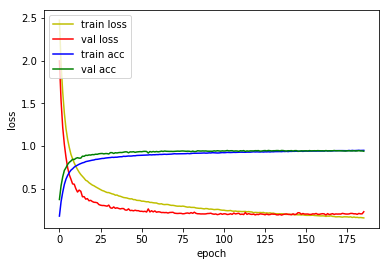

4815/4815 [==============================] - 2s 436us/sample - loss: 0.2305 - acc: 0.9294
Loss: 0.2305163688377428 Accuracy: 0.92938733

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2657 - acc: 0.2533
Epoch 00001: val_loss improved from inf to 1.51939, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_DO_6_conv_checkpoint/001-1.5194.hdf5
36805/36805 [==============================] - 34s 926us/sample - loss: 2.2657 - acc: 0.2533 - val_loss: 1.5194 - val_acc: 0.5549
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5222 - acc: 0.5046
Epoch 00002: val_loss improved from 1.51939 to 1.00714, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_DO_6_conv_checkpoint/002-1.0071.hdf5
36805/36805 [==============================] - 31s 853us/sample - loss: 1.5223 - acc: 0.5046 - val_loss: 1.0071 - val_acc: 0.7195
Epoch 3/500
36800/36805 [============================>.] - ETA

36800/36805 [============================>.] - ETA: 0s - loss: 0.3011 - acc: 0.9057
Epoch 00023: val_loss improved from 0.18291 to 0.18086, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_DO_6_conv_checkpoint/023-0.1809.hdf5
36805/36805 [==============================] - 31s 848us/sample - loss: 0.3010 - acc: 0.9057 - val_loss: 0.1809 - val_acc: 0.9495
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2929 - acc: 0.9087
Epoch 00024: val_loss did not improve from 0.18086
36805/36805 [==============================] - 31s 842us/sample - loss: 0.2930 - acc: 0.9087 - val_loss: 0.2079 - val_acc: 0.9348
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2862 - acc: 0.9092
Epoch 00025: val_loss did not improve from 0.18086
36805/36805 [==============================] - 31s 846us/sample - loss: 0.2862 - acc: 0.9092 - val_loss: 0.1952 - val_acc: 0.9420
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.

Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1857 - acc: 0.9401
Epoch 00049: val_loss did not improve from 0.13243
36805/36805 [==============================] - 31s 850us/sample - loss: 0.1857 - acc: 0.9401 - val_loss: 0.1370 - val_acc: 0.9588
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1811 - acc: 0.9422
Epoch 00050: val_loss did not improve from 0.13243
36805/36805 [==============================] - 31s 846us/sample - loss: 0.1810 - acc: 0.9422 - val_loss: 0.1505 - val_acc: 0.9569
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1821 - acc: 0.9428
Epoch 00051: val_loss improved from 0.13243 to 0.13053, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_DO_6_conv_checkpoint/051-0.1305.hdf5
36805/36805 [==============================] - 31s 850us/sample - loss: 0.1820 - acc: 0.9428 - val_loss: 0.1305 - val_acc: 0.9576
Epoch 52/500
36736/36805 [============================>.] - ETA: 

Epoch 77/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1256 - acc: 0.9590
Epoch 00077: val_loss did not improve from 0.12009
36805/36805 [==============================] - 31s 848us/sample - loss: 0.1256 - acc: 0.9590 - val_loss: 0.1206 - val_acc: 0.9625
Epoch 78/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1292 - acc: 0.9568
Epoch 00078: val_loss improved from 0.12009 to 0.11614, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_DO_6_conv_checkpoint/078-0.1161.hdf5
36805/36805 [==============================] - 31s 847us/sample - loss: 0.1291 - acc: 0.9568 - val_loss: 0.1161 - val_acc: 0.9641
Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1233 - acc: 0.9601
Epoch 00079: val_loss did not improve from 0.11614
36805/36805 [==============================] - 31s 848us/sample - loss: 0.1234 - acc: 0.9601 - val_loss: 0.1206 - val_acc: 0.9651
Epoch 80/500
36800/36805 [============================>.] - ETA: 

Epoch 106/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0913 - acc: 0.9688
Epoch 00106: val_loss did not improve from 0.11555
36805/36805 [==============================] - 31s 846us/sample - loss: 0.0913 - acc: 0.9688 - val_loss: 0.1216 - val_acc: 0.9639
Epoch 107/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0924 - acc: 0.9683
Epoch 00107: val_loss did not improve from 0.11555
36805/36805 [==============================] - 31s 843us/sample - loss: 0.0924 - acc: 0.9683 - val_loss: 0.1272 - val_acc: 0.9644
Epoch 108/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0926 - acc: 0.9697
Epoch 00108: val_loss did not improve from 0.11555
36805/36805 [==============================] - 31s 847us/sample - loss: 0.0926 - acc: 0.9697 - val_loss: 0.1308 - val_acc: 0.9667
Epoch 109/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0923 - acc: 0.9688
Epoch 00109: val_loss did not improve from 0.11555
36805/36805 [=

Epoch 136/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0707 - acc: 0.9765
Epoch 00136: val_loss did not improve from 0.11555
36805/36805 [==============================] - 31s 847us/sample - loss: 0.0707 - acc: 0.9765 - val_loss: 0.1424 - val_acc: 0.9632
Epoch 137/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0684 - acc: 0.9769
Epoch 00137: val_loss did not improve from 0.11555
36805/36805 [==============================] - 31s 841us/sample - loss: 0.0684 - acc: 0.9769 - val_loss: 0.1311 - val_acc: 0.9653

1D_CNN_custom_multi_3_GMP_DO_6_conv Model


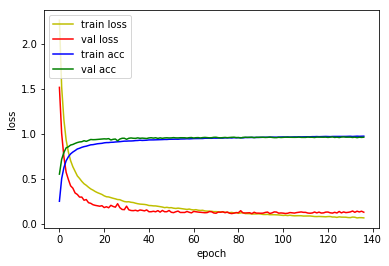

4815/4815 [==============================] - 2s 469us/sample - loss: 0.1525 - acc: 0.9537
Loss: 0.15245757239289498 Accuracy: 0.9536864

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1134 - acc: 0.3034
Epoch 00001: val_loss improved from inf to 1.29027, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_DO_7_conv_checkpoint/001-1.2903.hdf5
36805/36805 [==============================] - 36s 971us/sample - loss: 2.1134 - acc: 0.3034 - val_loss: 1.2903 - val_acc: 0.6154
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2678 - acc: 0.5864
Epoch 00002: val_loss improved from 1.29027 to 0.75220, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_DO_7_conv_checkpoint/002-0.7522.hdf5
36805/36805 [==============================] - 32s 868us/sample - loss: 1.2678 - acc: 0.5864 - val_loss: 0.7522 - val_acc: 0.7911
Epoch 3/500
36800/36805 [============================>.] - ETA

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1895 - acc: 0.9387
Epoch 00024: val_loss did not improve from 0.13000
36805/36805 [==============================] - 32s 861us/sample - loss: 0.1895 - acc: 0.9387 - val_loss: 0.1309 - val_acc: 0.9609
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1836 - acc: 0.9413
Epoch 00025: val_loss improved from 0.13000 to 0.12876, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_DO_7_conv_checkpoint/025-0.1288.hdf5
36805/36805 [==============================] - 32s 868us/sample - loss: 0.1836 - acc: 0.9413 - val_loss: 0.1288 - val_acc: 0.9625
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1783 - acc: 0.9438
Epoch 00026: val_loss improved from 0.12876 to 0.12314, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_DO_7_conv_checkpoint/026-0.1231.hdf5
36805/36805 [==============================] - 32s 869us/sample - loss: 0.1785 - acc: 0.9438 -

36800/36805 [============================>.] - ETA: 0s - loss: 0.0968 - acc: 0.9680
Epoch 00051: val_loss did not improve from 0.10043
36805/36805 [==============================] - 32s 860us/sample - loss: 0.0968 - acc: 0.9680 - val_loss: 0.1105 - val_acc: 0.9669
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0944 - acc: 0.9687
Epoch 00052: val_loss did not improve from 0.10043
36805/36805 [==============================] - 32s 864us/sample - loss: 0.0944 - acc: 0.9687 - val_loss: 0.1130 - val_acc: 0.9641
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0948 - acc: 0.9685
Epoch 00053: val_loss did not improve from 0.10043
36805/36805 [==============================] - 32s 863us/sample - loss: 0.0948 - acc: 0.9685 - val_loss: 0.1069 - val_acc: 0.9667
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0891 - acc: 0.9708
Epoch 00054: val_loss did not improve from 0.10043
36805/36805 [==================

Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0536 - acc: 0.9815
Epoch 00081: val_loss did not improve from 0.10043
36805/36805 [==============================] - 32s 864us/sample - loss: 0.0536 - acc: 0.9815 - val_loss: 0.1182 - val_acc: 0.9683
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0513 - acc: 0.9825
Epoch 00082: val_loss did not improve from 0.10043
36805/36805 [==============================] - 32s 868us/sample - loss: 0.0513 - acc: 0.9825 - val_loss: 0.1199 - val_acc: 0.9681
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0498 - acc: 0.9834
Epoch 00083: val_loss did not improve from 0.10043
36805/36805 [==============================] - 32s 866us/sample - loss: 0.0498 - acc: 0.9834 - val_loss: 0.1191 - val_acc: 0.9681
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0489 - acc: 0.9835
Epoch 00084: val_loss did not improve from 0.10043
36805/36805 [=====

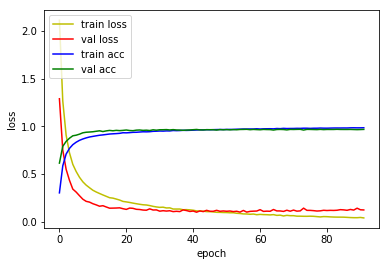

4815/4815 [==============================] - 2s 482us/sample - loss: 0.1510 - acc: 0.9514
Loss: 0.1509859473689199 Accuracy: 0.9514019

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9804 - acc: 0.3544
Epoch 00001: val_loss improved from inf to 1.05770, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_DO_8_conv_checkpoint/001-1.0577.hdf5
36805/36805 [==============================] - 38s 1ms/sample - loss: 1.9803 - acc: 0.3544 - val_loss: 1.0577 - val_acc: 0.6897
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0832 - acc: 0.6508
Epoch 00002: val_loss improved from 1.05770 to 0.67895, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_DO_8_conv_checkpoint/002-0.6790.hdf5
36805/36805 [==============================] - 33s 886us/sample - loss: 1.0833 - acc: 0.6507 - val_loss: 0.6790 - val_acc: 0.8057
Epoch 3/500
36800/36805 [============================>.] - ETA: 0

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1371 - acc: 0.9548
Epoch 00024: val_loss did not improve from 0.11975
36805/36805 [==============================] - 32s 881us/sample - loss: 0.1371 - acc: 0.9548 - val_loss: 0.1205 - val_acc: 0.9618
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1304 - acc: 0.9575
Epoch 00025: val_loss did not improve from 0.11975
36805/36805 [==============================] - 32s 882us/sample - loss: 0.1304 - acc: 0.9575 - val_loss: 0.1218 - val_acc: 0.9625
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1245 - acc: 0.9588
Epoch 00026: val_loss improved from 0.11975 to 0.11825, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_DO_8_conv_checkpoint/026-0.1183.hdf5
36805/36805 [==============================] - 32s 882us/sample - loss: 0.1245 - acc: 0.9588 - val_loss: 0.1183 - val_acc: 0.9627
Epoch 27/500
36800/36805 [============================>.] - ETA: 

Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0455 - acc: 0.9845
Epoch 00053: val_loss did not improve from 0.11132
36805/36805 [==============================] - 32s 882us/sample - loss: 0.0455 - acc: 0.9845 - val_loss: 0.1314 - val_acc: 0.9655
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0455 - acc: 0.9848
Epoch 00054: val_loss did not improve from 0.11132
36805/36805 [==============================] - 32s 880us/sample - loss: 0.0454 - acc: 0.9848 - val_loss: 0.1318 - val_acc: 0.9658
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0446 - acc: 0.9850
Epoch 00055: val_loss did not improve from 0.11132
36805/36805 [==============================] - 32s 883us/sample - loss: 0.0446 - acc: 0.9850 - val_loss: 0.1371 - val_acc: 0.9665
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0430 - acc: 0.9851
Epoch 00056: val_loss did not improve from 0.11132
36805/36805 [=====

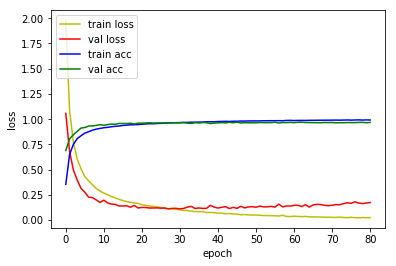

4815/4815 [==============================] - 2s 472us/sample - loss: 0.1654 - acc: 0.9491
Loss: 0.16542160726101104 Accuracy: 0.94911736



In [10]:
base = '1D_CNN_custom_multi_3_GMP_DO'

for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    model = build_cnn(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_multi_3_GMP_DO'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 9):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_multi_3_GMP_DO_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 64)    384         input_7[0][0]                    
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 64)    0           conv1d_33[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_33 (MaxPooling1D) (None, 5333, 64)     0           activation_33[0][0]              
__________________________________________________________________

4815/4815 [==============================] - 2s 454us/sample - loss: 0.4084 - acc: 0.8768
Loss: 0.40840566355119984 Accuracy: 0.8768432

1D_CNN_custom_multi_3_GMP_DO_5_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_40 (Conv1D)              (None, 16000, 64)    384         input_9[0][0]                    
__________________________________________________________________________________________________
activation_40 (Activation)      (None, 16000, 64)    0           conv1d_40[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_40 (MaxPooling1

4815/4815 [==============================] - 2s 487us/sample - loss: 0.1525 - acc: 0.9537
Loss: 0.15245757239289498 Accuracy: 0.9536864

1D_CNN_custom_multi_3_GMP_DO_7_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, 16000, 64)    384         input_11[0][0]                   
__________________________________________________________________________________________________
activation_51 (Activation)      (None, 16000, 64)    0           conv1d_51[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_51 (MaxPooling1

4815/4815 [==============================] - 2s 517us/sample - loss: 0.1654 - acc: 0.9491
Loss: 0.16542160726101104 Accuracy: 0.94911736


In [12]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
# base = '1D_CNN_custom_DO'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_multi_3_GMP_DO_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 64)    384         input_7[0][0]                    
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 64)    0           conv1d_33[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_33 (MaxPooling1D) (None, 5333, 64)     0           activation_33[0][0]              
__________________________________________________________________

4815/4815 [==============================] - 2s 500us/sample - loss: 0.4232 - acc: 0.8739
Loss: 0.4232453409385087 Accuracy: 0.87393564

1D_CNN_custom_multi_3_GMP_DO_5_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_40 (Conv1D)              (None, 16000, 64)    384         input_9[0][0]                    
__________________________________________________________________________________________________
activation_40 (Activation)      (None, 16000, 64)    0           conv1d_40[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_40 (MaxPooling1

4815/4815 [==============================] - 3s 538us/sample - loss: 0.1706 - acc: 0.9541
Loss: 0.1706164086533484 Accuracy: 0.95410174

1D_CNN_custom_multi_3_GMP_DO_7_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, 16000, 64)    384         input_11[0][0]                   
__________________________________________________________________________________________________
activation_51 (Activation)      (None, 16000, 64)    0           conv1d_51[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_51 (MaxPooling1

4815/4815 [==============================] - 3s 574us/sample - loss: 0.2334 - acc: 0.9522
Loss: 0.23342520691474236 Accuracy: 0.9522326
